In [2]:
from datetime import datetime
from utils.binaries import *
from utils.plotting import *
import pickle
import uproot

07:29:10 [INFO] utils          -- (<99999ms) -- import logging
07:29:10 [INFO] utils.binaries -- (  +166ms) -- import numpy as np
07:29:10 [INFO] utils.binaries -- (    +7ms) -- import uncertainties
07:29:10 [INFO] utils.binaries -- (  +177ms) -- import pandas as pd
07:29:10 [INFO] utils.binaries -- (    +2ms) -- import binaries.tools as tools
07:29:10 [INFO] utils.plotting -- (  +367ms) -- import matplotlib.pyplot as plt
07:29:11 [INFO] utils.plotting -- (  +635ms) -- import seaborn as so
07:29:11 [DBUG] utils.plotting -- (   +13ms) -- font size set to 9.5
07:29:11 [DBUG] utils.plotting -- (    +1ms) -- label size set to 13.0
07:29:11 [DBUG] utils.plotting -- (    +1ms) -- figure size set to [6.6, 3.3]
07:29:11 [DBUG] utils.plotting -- (    +1ms) -- markersize set to 2.0
07:29:11 [DBUG] utils.plotting -- (    +1ms) -- usetex set to False
07:29:11 [INFO] utils.plotting -- (    +2ms) -- import plotting.tools as plot


In [9]:
def get_start_stop_variance(file):
    path='../NightSkyBackground'
    file = uproot.open(f'{path}/{file}:AugerUpTime')
    variances = np.array(file['ADCVariance'].array(), dtype=float)[:,-3:,:]
    shutter_open_fraction = np.array(file['ShutterFraction8ADC'].array())[:,-3:]
    variances *= shutter_open_fraction[:, :, np.newaxis]

    indices = [i for i, var in enumerate(variances) if np.sum(var) != 0]
    start, stop = file['uptime_gpsStart'].array(), file['uptime_gpsStop'].array()
    return start[indices], stop[indices], variances[indices]

def get_calibration_constant(date, method='xy'):

    results = '/cr/data01/filip/xy-calibration/results/'

    # force preclean usage
    # date = '2023-07'

    # force postclean usage
    # date = '2023-11'

    if date < '2023-11':        # before mirror cleaning
        heat1_run = '6020x'
        heat2_run = '6025'
        heat3_run = '6031x'

    else:                       # after mirror cleaning
        heat1_run = '6070'
        heat2_run = '6075'
        heat3_run = '6066'

    heat1 = pd.read_csv(f'{results}/outCorr_{heat1_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    heat2 = pd.read_csv(f'{results}/outCorr_{heat2_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    heat3 = pd.read_csv(f'{results}/outCorr_{heat3_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    
    match method.lower():
        case 'xy':
            calibration_constants = heat1.calibConstCorr.values, heat2.calibConstCorr.values, heat3.calibConstCorr.values
        case 'cala':
            calibration_constants = heat1.stdCalib.values, heat2.stdCalib.values, heat3.stdCalib.values
        case _:
            calibration_constants = np.ones((3, 440))

    return calibration_constants

In [4]:
def read_data():

    with open('pickle_files/gps-second-dict_2023-09-01_2023-12-31.pickle', 'rb') as f: time = pickle.load(f)['Heat']

    # get bandwidth/gain/variance
    with open('pickle_files/bandwidth-dict_2023-09-01_2023-12-31.pickle', 'rb') as f: bandwidth = pickle.load(f)['Heat']
    with open('pickle_files/gain-dict_2023-09-01_2023-12-31.pickle', 'rb') as f: gain = pickle.load(f)['Heat']
    with open('pickle_files/variance-dict_2023-09-01_2023-12-31.pickle', 'rb') as f: variance = pickle.load(f)['Heat']
    with open('pickle_files/calibration-constants-dict_2023-09-01_2023-12-31.pickle', 'rb') as f: calib = pickle.load(f)['Heat']
    with open('pickle_files/photon-flux-dict_2023-09-01_2023-12-31.pickle', 'rb') as f: flux = pickle.load(f)['Heat']

    t, b, g, c, f, var = [], [], [], [], [], []
    for id in time.keys():
        t.append(time[id]['gps-second'])
        b.append(bandwidth[id]['bandwidth'])
        g.append(gain[id]['gain'])
        c.append(calib[id]['calibration-constants'])
        f.append(flux[id]['photon-flux'])
        var.append(variance[id]['variance'])

    return t, b, g, c, f, var

def build_day_average(data):
    gps_unix_offset = 315964800
    day_avgs = {'0' : {}, '1' : {}, '2': {}}
    for i, telescope in enumerate(zip(*data)):
        n_data_to_average = 0
        for t, b, g, c, f, var in zip(*telescope):
            if np.mean(var) <= 8: continue

            n_data_to_average += 1
            timestamp = datetime.fromtimestamp(t + gps_unix_offset)
            day_str = timestamp.date().__str__()

            try:
                _ = day_avgs[str(i)][day_str]
            except KeyError:
                day_avgs[str(i)][day_str] = {key : np.zeros(440) for key in ['gain', 'bandwidth', 'calib', 'flux', 'variance']}

            day_avgs[str(i)][day_str]['gain'] += g
            day_avgs[str(i)][day_str]['bandwidth'] += b
            day_avgs[str(i)][day_str]['calib'] += c
            day_avgs[str(i)][day_str]['flux'] += f
            day_avgs[str(i)][day_str]['variance'] += var

        day_avgs[str(i)][day_str]['gain'] /= n_data_to_average
        day_avgs[str(i)][day_str]['bandwidth'] /= n_data_to_average
        day_avgs[str(i)][day_str]['calib'] /= n_data_to_average
        day_avgs[str(i)][day_str]['flux'] /= n_data_to_average
        day_avgs[str(i)][day_str]['variance'] /= n_data_to_average

    return day_avgs


In [5]:
data = read_data()
day_averages = build_day_average(data)

/tmp/ipykernel_2070024/3534931091.py:16: RuntimeWarning: divide by zero encountered in divide
  K_v = 10 / (2 * averages['gain'] * averages['bandwidth'])


before: 8.492e+10, after: 1.205e+11
percentage difference: 41.93%
before: 5.730e+10, after: 5.053e+10
percentage difference: -11.82%
before: 4.619e+10, after: 5.499e+10
percentage difference: 19.06%


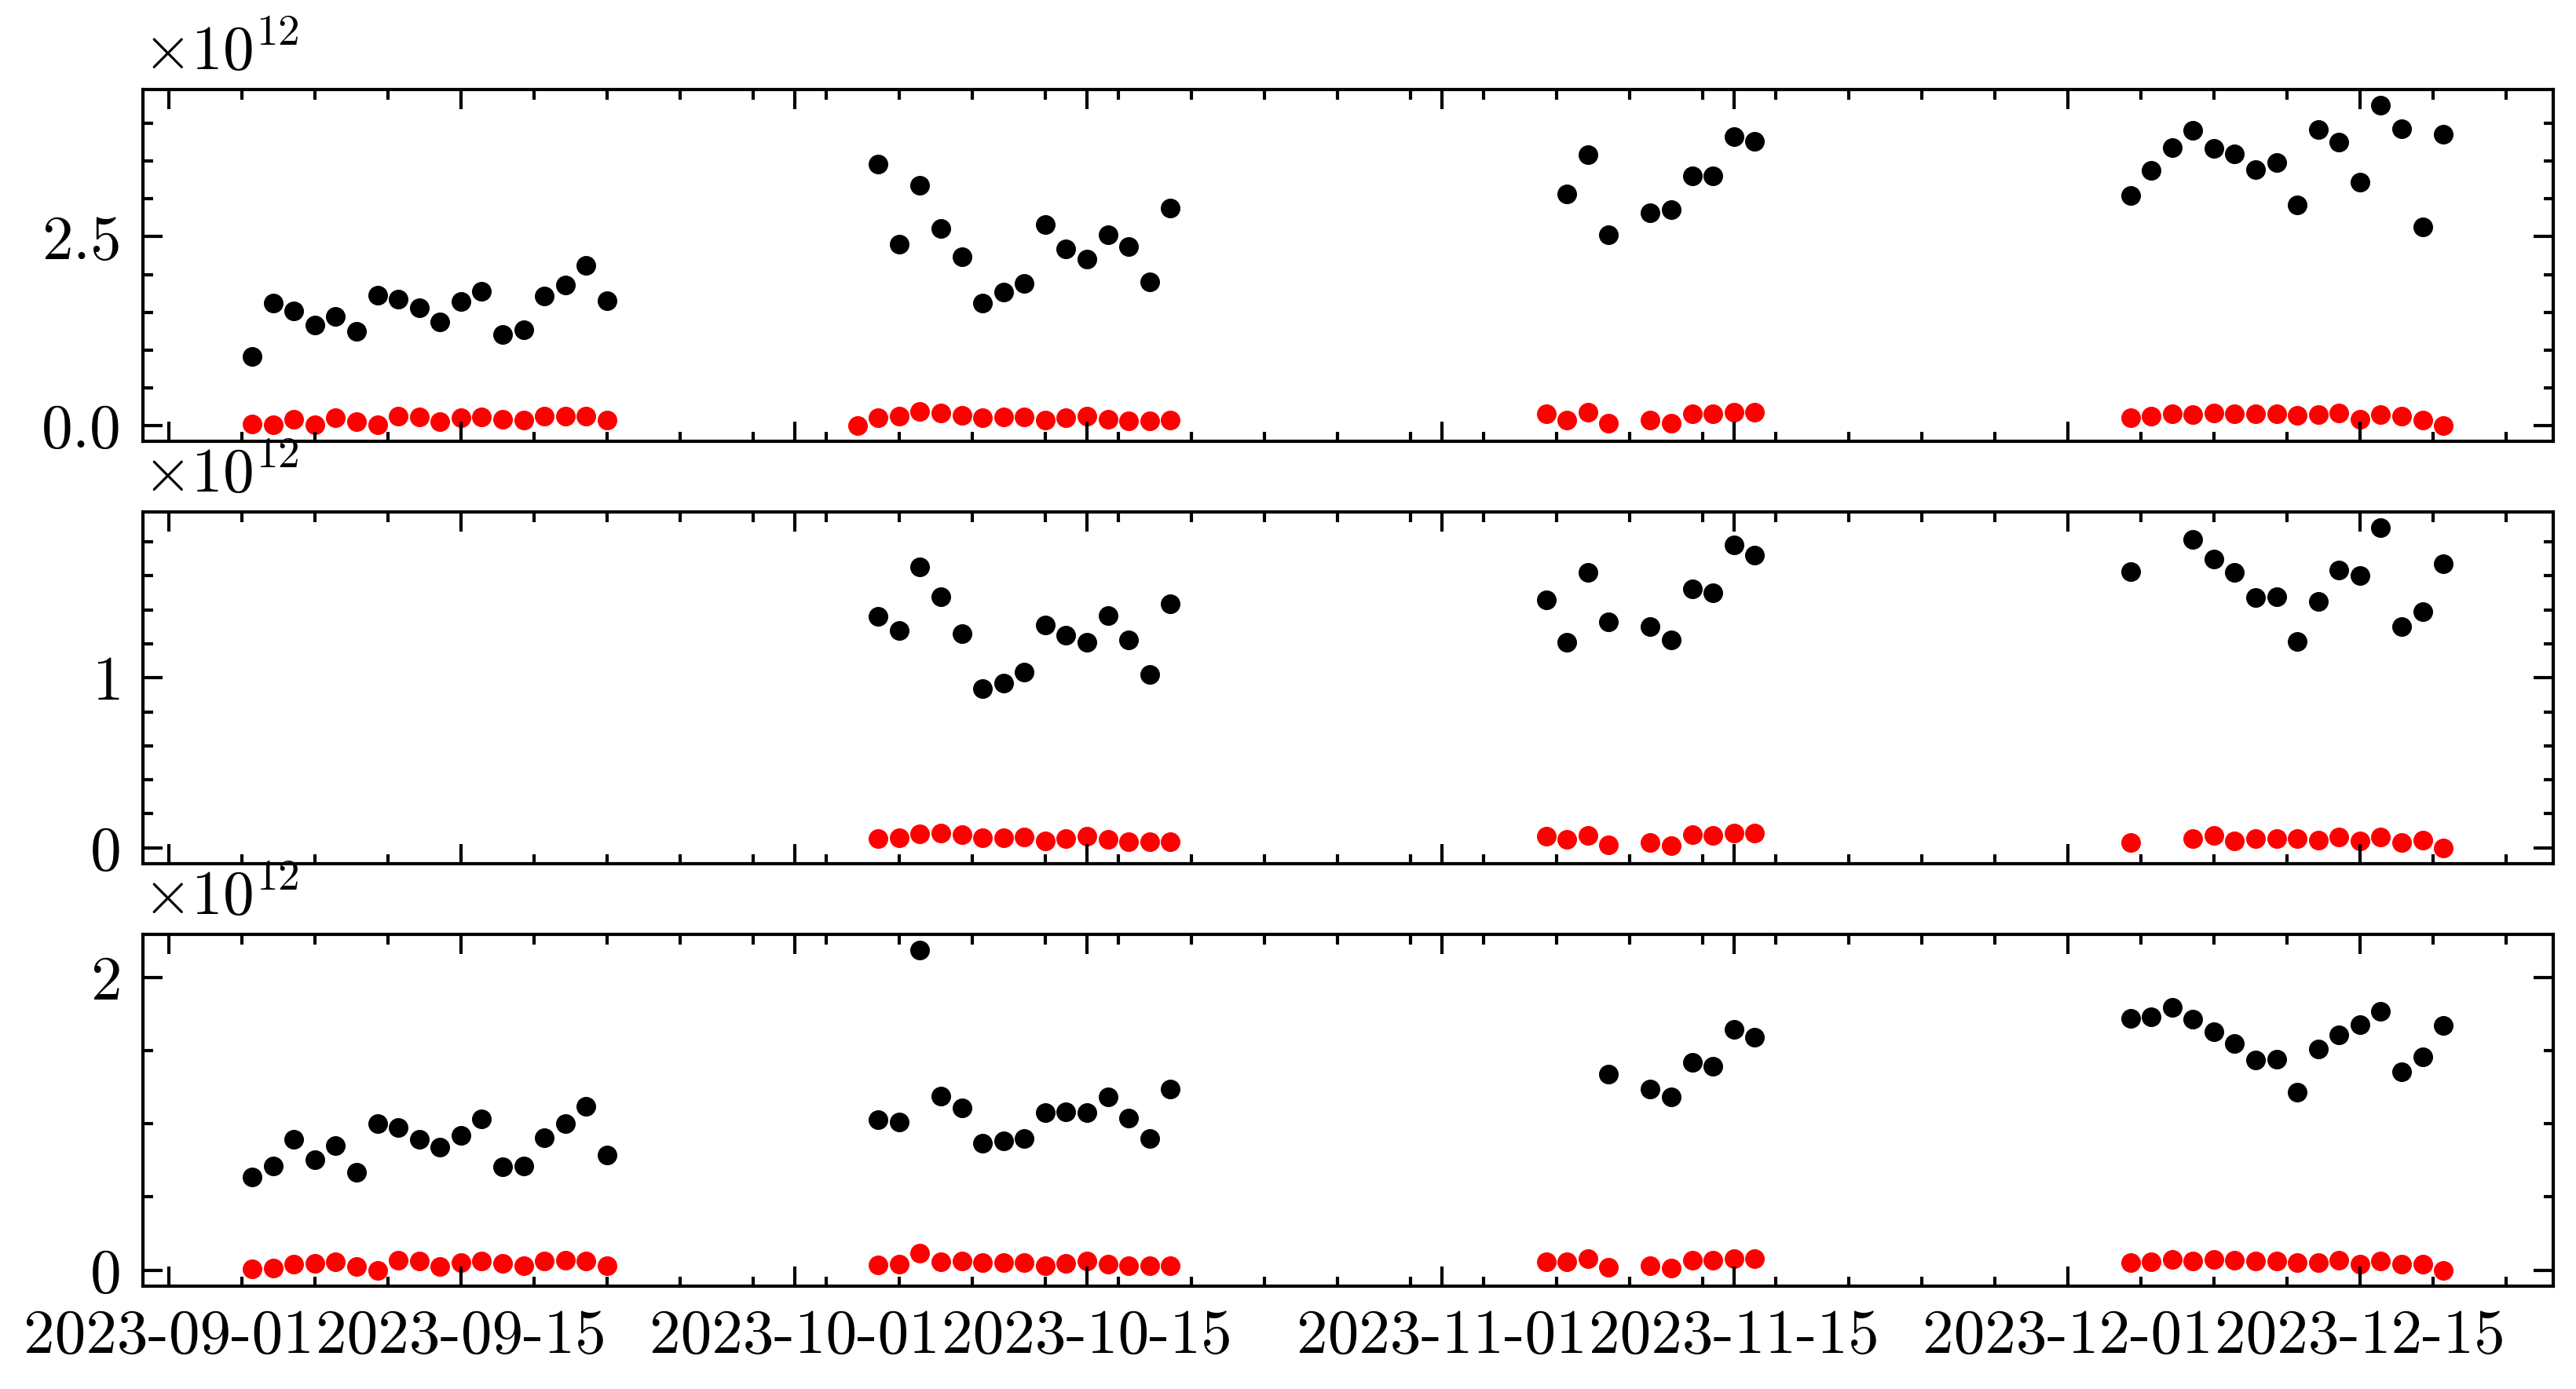

In [7]:
fig, axes = plt.subplots(3, 1, sharex=True)

deltaT      = 100e-9        # in s, HEAT sampling frequency
Area        = 3.8           # in m^2, Aperture area
omega       = 5.94e-4       # in sr, pixel acceptance
F_lambda    = 73.3e-9       # in m, spectral response

for ax, telescope in zip(axes, day_averages.values()):
    flux_before_mc, flux_after_mc = [], []
    for day, averages in telescope.items():
        x = datetime.strptime(day, "%Y-%m-%d")

        before_mc = x < datetime(2023, 11, 1, 0, 0, 0)

        G, F, V = averages['gain'], averages['bandwidth'], averages['variance']
        K_v = 10 / (2 * averages['gain'] * averages['bandwidth'])
        dK_v = K_v/np.sqrt(5) * np.sqrt(G**2 * F.std()**2 + F**2 * G.std()**2)
        pseudo_flux = averages['variance'] * K_v * averages['calib']
        pseudo_flux /= (deltaT * Area * omega * F_lambda)
        # pseudo_flux_error = pseudo_flux * np.sqrt(relative_flux_variance)

        # relative_flux_variance = dK_v**2/K_v**2 + V.std()**2/V + averages['calib'].std()**2/averages['calib']

        # ax.errorbar(x, averages['gain'].mean(), averages['gain'].std(), fmt='o', capsize=2, c='k')
        # ax.errorbar(x, averages['bandwidth'].mean(), averages['bandwidth'].std(), fmt='o', capsize=2, c='b')
        ax.scatter(x, averages['flux'].mean(), c='r')#, averages['flux'].std(), fmt='o', c='k')
        ax.scatter(x, pseudo_flux.mean(), c='k')#, pseudo_flux_error.mean(), fmt='o', capsize=2, c='r')

        if before_mc:
            flux_before_mc.append(averages['flux'].mean())
        else:
            flux_after_mc.append(averages['flux'].mean())

    # ax.set_ylim(0, 5e-5)
    # ax.set_yscale('log')
            
    print(f'before: {np.mean(flux_before_mc):.3e}, after: {np.mean(flux_after_mc):.3e}')
    print(f'percentage difference: {(np.mean(flux_after_mc) - np.mean(flux_before_mc)) / np.mean(flux_before_mc) * 100:.2f}%')

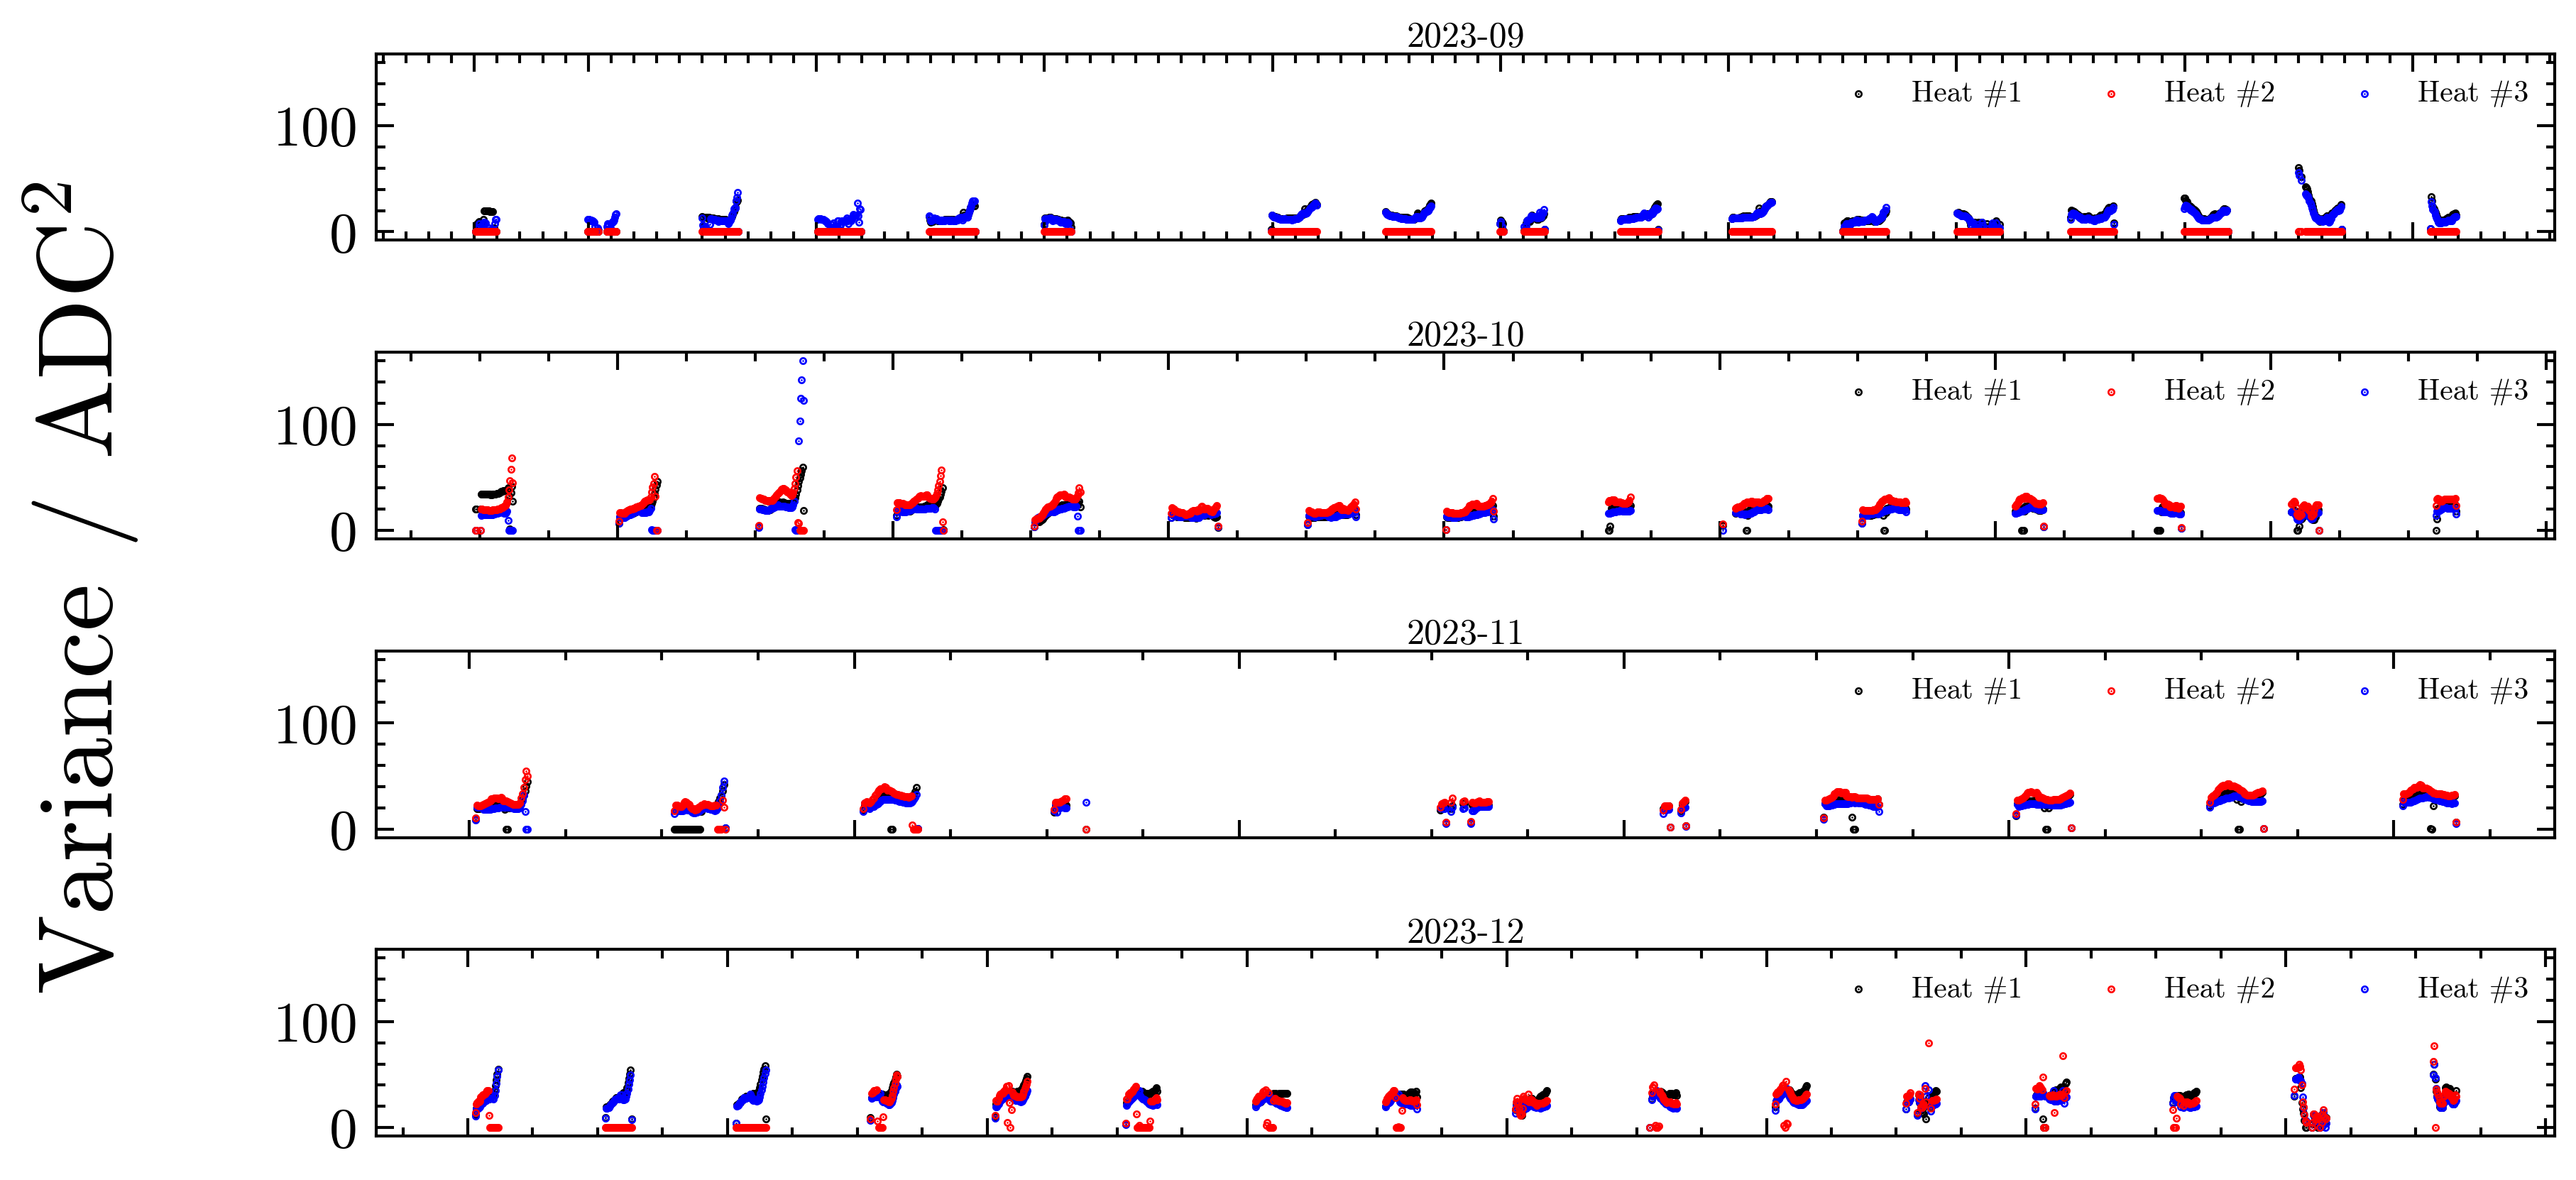

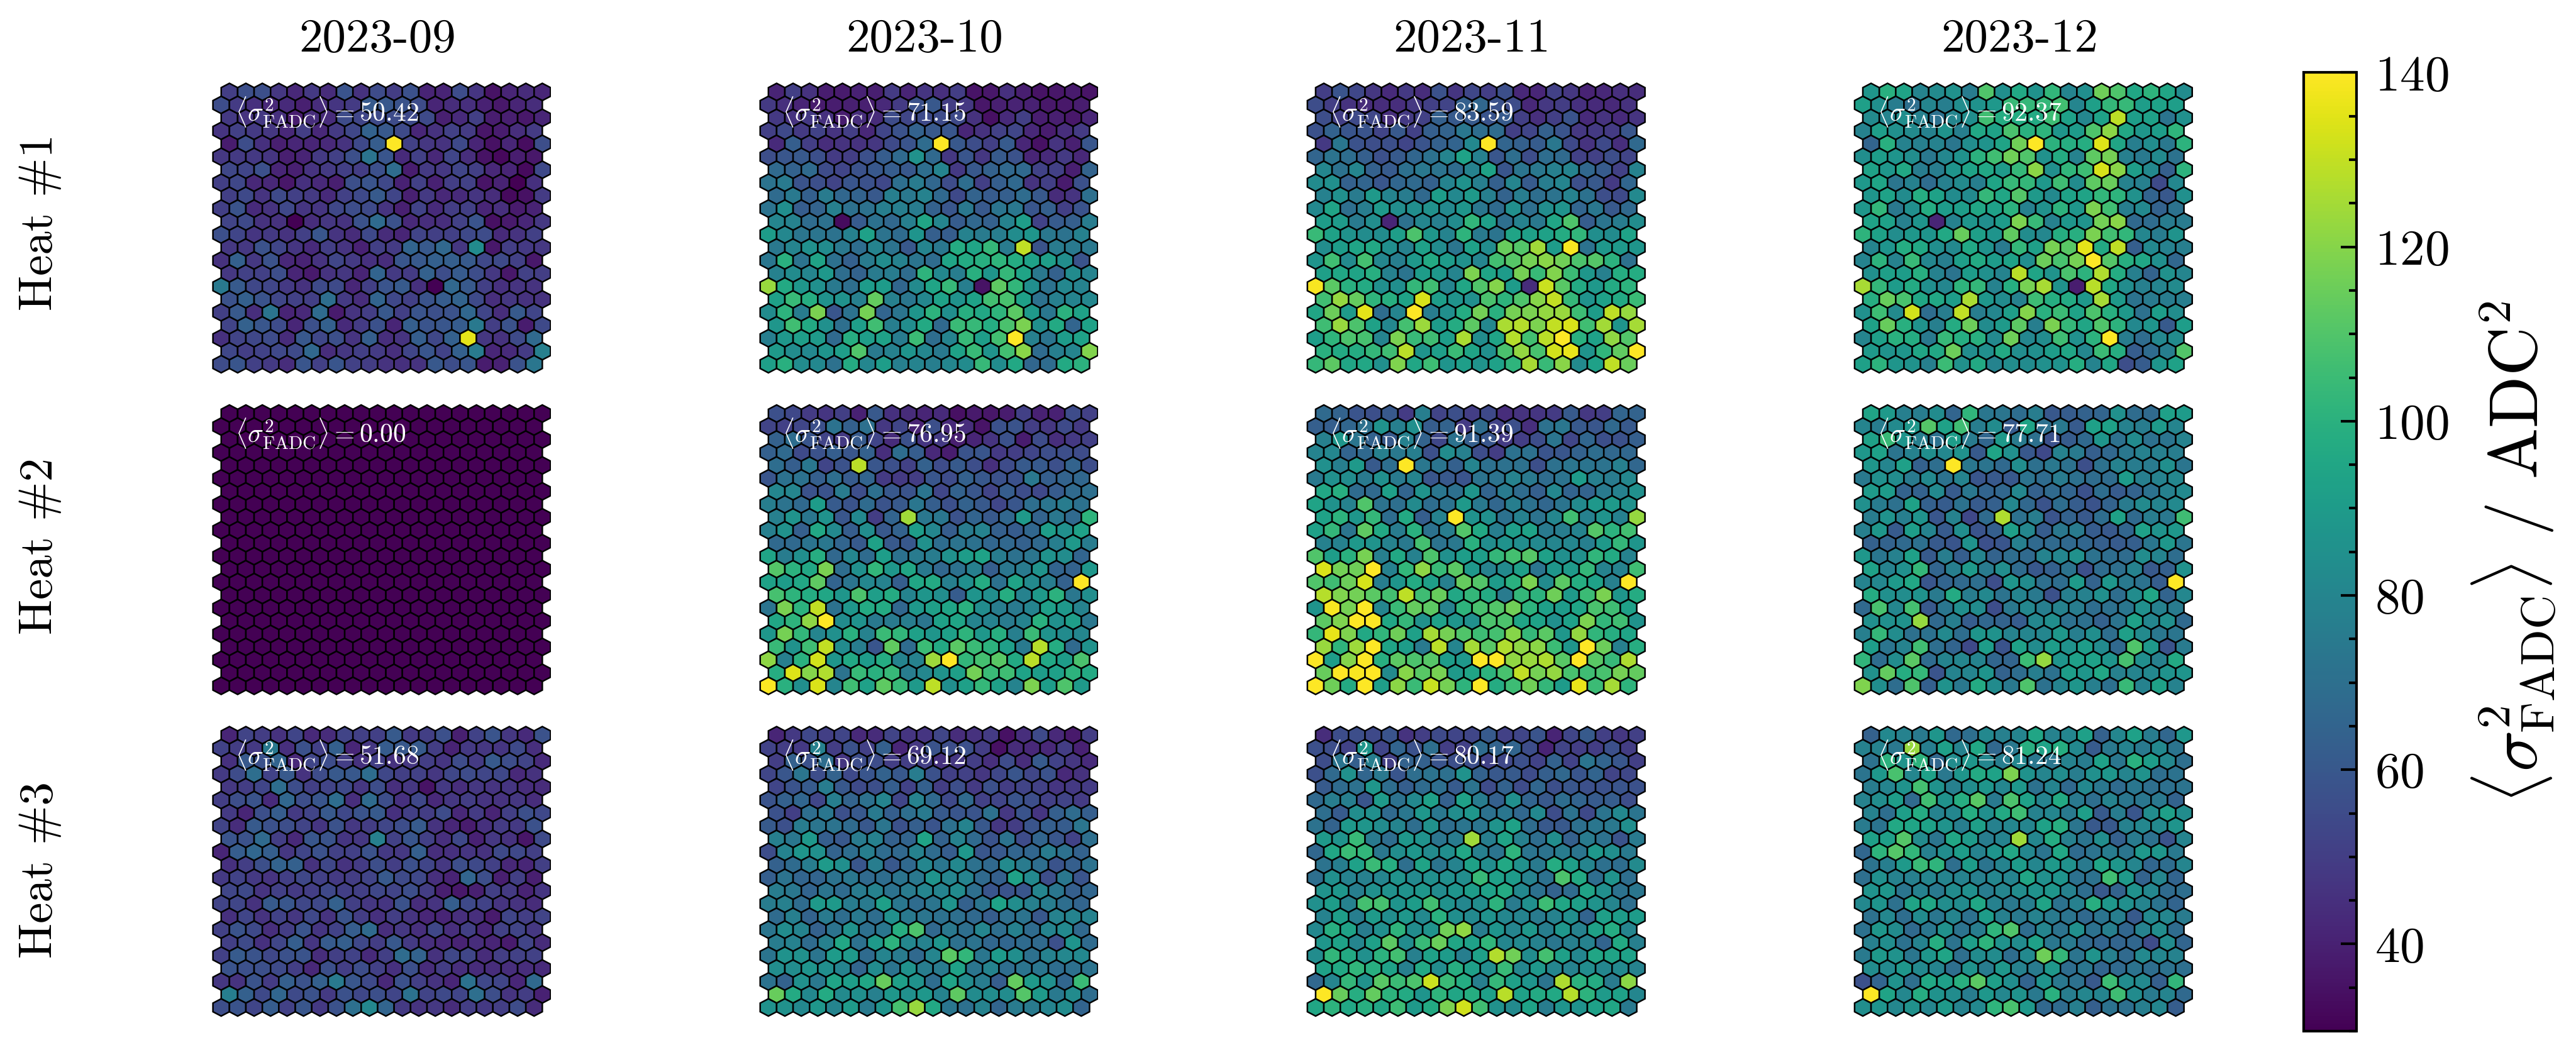

In [10]:
from datetime import datetime
from utils.Auger.FD import PixelPlot
from matplotlib.gridspec import GridSpec

files = [#'2022-10-01-12utc.root',
        #  '2023-03-01-12utc.root',
        #  '2023-04-01-12utc.root',
        #  '2023-05-01-12utc.root',
        #  '2023-06-01-12utc.root',
        #  '2023-07-01-12utc.root', 
        #  '2023-08-01-12utc.root', 
         '2023-09-01-12utc.root', 
         '2023-10-01-12utc.root', 
         '2023-11-01-12utc.root', 
         '2023-12-01-12utc.root',
        #  '2024-01-01-12utc.root'
         ]

fig1, laxes = plt.subplots(len(files), 1, sharey=True)
fig1.text(.02, 0.5, 'Variance / $\mathrm{ADC}^2$', rotation=90,
         fontdict={'ha' : 'center', 'va' : 'center', 'fontsize' : 18})
plt.subplots_adjust(hspace=0.6)

fig2 = plt.figure()
gs = GridSpec(
        3,
        len(files) + 1,
        figure=fig2,
        width_ratios=[1 for _ in files] + [0.1],
        height_ratios = [1/3, 1/3, 1/3],
    )
gs.update(left=0.05, right=0.95, wspace=0.05, hspace=0.02)

fig2.text(.02, 0.76, 'Heat #1', rotation=90,
          fontdict={'ha' : 'center', 'va' : 'center', 'fontsize' : 9})
fig2.text(.02, 0.5, 'Heat #2', rotation=90,
          fontdict={'ha' : 'center', 'va' : 'center', 'fontsize' : 9})
fig2.text(.02, 0.24, 'Heat #3', rotation=90,
          fontdict={'ha' : 'center', 'va' : 'center', 'fontsize' : 9})

method = 'xy'
if method == '_':
    vmin, vmax = 0, 50
    name = 'raw_variance'
elif method == 'cala':
    vmin, vmax = 30, 140
    name = 'CalA_normalized'
elif method == 'xy':
    vmin, vmax = 30, 140
    name = 'XY_normalized'

means_before, means_after = [], []

for col, (file, lax) in enumerate(zip(files, laxes)):

    start, stop, var = get_start_stop_variance(file)

    skip = 35 if file == '2022-10-01-12utc.root' else 0
    timestamps = [datetime.fromtimestamp(0.5*(e+b)) for e, b in zip(start, stop)]
    lax.set_title(file[:7], pad=1, fontsize=6)
    lax.set_xticklabels([])

    lax.scatter(timestamps[skip:], np.mean(var[skip:,0,:], axis=1), label='Heat #1', s=0.1)
    lax.scatter(timestamps[skip:], np.mean(var[skip:,1,:], axis=1), label='Heat #2', s=0.1, zorder=10)
    lax.scatter(timestamps[skip:], np.mean(var[skip:,2,:], axis=1), label='Heat #3', s=0.1)
    lax.legend(ncols=3, fontsize=5)

    ax1, ax2, ax3 = [fig2.add_subplot(gs[i,col]) for i in range(3)]
    means = [np.median(var[:, i,:], axis=0) for i in range(3)]

    # normalize with calibration constants
    calibration_constants = get_calibration_constant(file[:7], method)
    means = np.array(means) * calibration_constants # * K_V?

    PixelPlot(means[0], ax=ax1, lw=0.3, vmin=vmin, vmax=vmax)
    PixelPlot(means[1], ax=ax2, lw=0.3, vmin=vmin, vmax=vmax)
    PixelPlot(means[2], ax=ax3, lw=0.3, vmin=vmin, vmax=vmax)
    ax1.set_title(file[:7], pad=4, fontsize=9)

    if file[:7] < '2023-11':
        if file[:7] in ['2023-09', '2023-07']:                      # skip heat 2 due to UpTime being down
            heat1, heat2, heat3 = np.mean(means, axis=1)
            heat2 = np.nan
            means_before.append([heat1, heat2, heat3])        
        else:
            means_before.append(np.mean(means, axis=1))
    else:
        means_after.append(np.mean(means, axis=1))

    ax1.text(0.09, 0.93, fr'$\langle\mathrm{{\sigma^2_\mathrm{{FADC}}}}\rangle = {np.mean(means[0]):.2f}$', c='white', fontdict={'fontsize' : 5, 'ha' : 'left', 'va' : 'top', 'weight' : 'bold'}, transform=ax1.transAxes)
    ax2.text(0.09, 0.93, fr'$\langle\mathrm{{\sigma^2_\mathrm{{FADC}}}}\rangle = {np.mean(means[1]):.2f}$', c='white', fontdict={'fontsize' : 5, 'ha' : 'left', 'va' : 'top', 'weight' : 'bold'}, transform=ax2.transAxes)
    ax3.text(0.09, 0.93, fr'$\langle\mathrm{{\sigma^2_\mathrm{{FADC}}}}\rangle = {np.mean(means[2]):.2f}$', c='white', fontdict={'fontsize' : 5, 'ha' : 'left', 'va' : 'top', 'weight' : 'bold'}, transform=ax3.transAxes)

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
norm = Normalize(vmin, vmax)

fig2.colorbar(ScalarMappable(norm, 'viridis'), cax=fig2.add_subplot(gs[:, len(files)]),
              label=r'$\langle\mathrm{\sigma^2_\mathrm{{FADC}}}\rangle$ / $\mathrm{ADC}^2$')